In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from pathlib import Path

data = Path('data')

In [62]:
users = pd.read_csv(data / "UserList.csv")
users["user_id"].nunique(), users["location"].nunique()

FileNotFoundError: [Errno 2] No such file or directory: 'data/UserList.csv'

In [4]:
# users whose location is not null
users = users[users["location"].notnull()]
users["user_id"].nunique(), users["location"].nunique()

(156774, 55280)

Filtered dataset: users who have birth date, location and gender filled. So it contains lot less animelists data.

The filtered dataset contains:

116 133 unique users with demographic data
35 802 010 records in anime lists
20 726 794 of them have ratings
14 474 unique anime

In [5]:
users_filtered = pd.read_csv(data / "users_filtered.csv")
users_filtered["user_id"].nunique(), users_filtered["location"].nunique()

(116133, 42835)

cleaned version of the filtered dataset: 
- has trucated all users with ridiculously large number of episodes in anime which obviously don't have that much episodes, watched episodes larger than number of episodes in individual anime were fixed and seen episodes and watch time were recalculated accordingly. 
- For some users, last online was 1900 year, just weird values, so their last activity was inferred from their last animelist update timestamp.
- Many users incorrectly filled number of rewatched episodes. 
- For anime where more episodes have been watched than that anime has episodes, watched episodes have been rewritten to number of episodes in that anime. Watch time and number of watched episodes have been fixed accordingly.
- Users too young and too old obviously were truncated too.
- 6 users with most episodes seen, suspiciously lots of episodes, were truncated here too. That is too few users to affect any statistics.

In [6]:
users_cleaned = pd.read_csv(data / "users_cleaned.csv")
users_cleaned["user_id"].nunique(), users_cleaned["location"].nunique()

(108711, 40438)

In [7]:
locations = users["location"].unique()
len(locations)

55280

In [8]:
from functools import partial
from geopy.geocoders import Nominatim
from deep_translator import GoogleTranslator

import country_converter as coco
coco.logging.getLogger().setLevel(coco.logging.ERROR)


translator = GoogleTranslator(source="auto", target="en")
geolocator = Nominatim(user_agent="GoogleV3")
geocode = partial(geolocator.geocode, language="en")

def findCountry(location):
    if location.isdigit() : 
        print(location, "(is digit)")
        return ""
    
    try:
        result = geocode(location, timeout=5)
    except:
        print(location, "(geocode)")
        return ""
    if result is not None :
        country = result.address.split(",")[-1].strip()
        return country
    
    country = coco.convert(names=location, to='name_short')
    if country != "not found" :
        return country    
    
    translated = translator.translate(location)
    if translated is None:
        print(location, "(translation not found)")
        return ""
    if translated == location :
        print(location, "(not found)")
        return ""
    
    try:
        result = geocode(translated, timeout=5)
    except:
        print(location, "->", translated, "(geocode)")
        return ""
    if result is not None :
        country = result.address.split(",")[-1].strip()
        return country
    
    country = coco.convert(names=translated, to='name_short')
    if country != "not found" :
        return country    
    print(location, "->", translated, "(not found)")
    return ""

In [9]:
with open("countries.pickle", "rb") as f:
    countries = pickle.load(f)

countries, len(countries)

(['India',
  'Philippines',
  'United States',
  'Mexico',
  'Malaysia',
  'Netherlands',
  'United States',
  'Poland',
  'Sweden',
  'United States',
  'United Kingdom',
  'Hungary',
  '',
  'United Kingdom',
  'Philippines',
  'United States',
  'Brazil',
  'Mexico',
  'Australia',
  'Canada',
  'United States',
  'United States',
  'United States',
  '',
  'United States',
  'Brazil',
  'Austria',
  'Canada',
  'Germany',
  'United States',
  '',
  'Canada',
  'Iran',
  'Romania',
  'Brazil',
  'Austria',
  'Russia',
  'Brazil',
  'United States',
  'United States',
  'Russia',
  '',
  'India',
  'Bulgaria',
  'Australia',
  'Argentina',
  'Egypt',
  'Brazil',
  'United States',
  '',
  '',
  'Philippines',
  'Brazil',
  'United States',
  'United States',
  'Portugal',
  'United States',
  'United States',
  'Poland',
  'Poland',
  'United States',
  'United States',
  'Venezuela',
  'France',
  'Netherlands',
  'United States',
  'Brazil',
  'Brazil',
  'Saudi Arabia',
  '',
  'U

In [10]:
with open("location_to_country.pickle", "rb") as f:
    location_to_country = pickle.load(f)
location_to_country, len(location_to_country)

({'Chennai, India ': 'India',
  'Manila': 'Philippines',
  'Detroit,Michigan': 'United States',
  'Nayarit, Mexico': 'Mexico',
  'Malaysia, Kuantan': 'Malaysia',
  'Nijmegen, Nederland': 'Netherlands',
  'California': 'United States',
  'Poland': 'Poland',
  'Norberg Sweden': 'Sweden',
  'Nebraska': 'United States',
  'England,Manchester': 'United Kingdom',
  '~ Hungary ~': 'Hungary',
  'Where even am I': '',
  'United Kingdom': 'United Kingdom',
  'manila': 'Philippines',
  'home': 'United States',
  'socal =)': 'Brazil',
  'Mexico': 'Mexico',
  'Sydney Australia N.S.W': 'Australia',
  'Hamilton Ontario': 'Canada',
  'Nevada USA': 'United States',
  'Chicago, IL': 'United States',
  'San Jose, CA': 'United States',
  'somewhere really hot': '',
  'Guess': 'United States',
  'Camaragibe, Pernambuco': 'Brazil',
  'ａｕｓｔｒｉａ。': 'Austria',
  'Canada': 'Canada',
  'Rhineland-Palatinate, Germany': 'Germany',
  'Philadelphia PA': 'United States',
  'The Crimson World (England :P)': '',
  'Carb

In [11]:
type(location_to_country["Cookieland Antarctica"])

list

In [12]:
df_location_country = pd.DataFrame.from_dict(
    location_to_country, orient="index", columns=["country"]
)
df_location_country.index.name = "location"
df_location_country = df_location_country.reset_index()
df_location_country.country = df_location_country.country.apply(lambda x: str(x))
df_location_country.to_csv("location_to_country.csv", index=False)

df_location_country

,location,country
0,"Chennai, India",India
1,Manila,Philippines
2,"Detroit,Michigan",United States
3,"Nayarit, Mexico",Mexico
4,"Malaysia, Kuantan",Malaysia
...,...,...
55275,Żelkowo,Poland
55276,somewhere .....\{◕◡◕}/,China
55277,Poland:,Poland
55278,"nhollywood, california",


In [13]:
df_location_country_clean = df_location_country[
    ~df_location_country["country"].str.contains(",")
]
df_location_country_clean

# transform as a dictionary
location_country_clean = df_location_country_clean.set_index("location")["country"].to_dict()

# Users

In [20]:
users["country"] = users["location"].map(location_country_clean)
users

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,country
0,karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0,India
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0,Philippines
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0,United States
3,bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0,Mexico
5,terune_uzumaki,327311,5,5,0,0,0,15.20,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0,Malaysia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302657,Scarlet95,2478991,6,103,10,8,54,47.94,Female,Belgium,1995-10-17,NaN,2013-04-24,2016-12-18 08:41:00,7.40,1.0,2906.0,Belgium
302662,TheClockworkGuy,4273353,5,77,8,12,61,48.03,Male,Yharnam,NaN,NaN,2014-11-23,1900-05-22 02:49:00,6.85,0.0,2826.0,United States
302668,ichinitan,4531649,3,24,5,0,246,8.72,NaN,"Alexandria, Virginia",2000-05-12,NaN,2015-04-01,2017-10-12 14:22:00,9.46,0.0,528.0,United States
302671,Torasori,3975907,22,239,0,4,176,86.88,Male,"Latvia, Riga",1998-11-18,NaN,2014-07-30,2018-05-24 21:34:46,8.98,47.0,5313.0,Latvia


In [21]:
users["country"].value_counts()

United States                                  34854
Brazil                                          8234
Poland                                          8076
United Kingdom                                  7915
Canada                                          7429
                                               ...  
676                                                1
France - La Réunion - Tromelin Island (EEZ)        1
St. Vincent and the Grenadines                     1
Soul Buoy                                          1
Kiribati                                           1
Name: country, Length: 251, dtype: int64

In [22]:
# number of users whose country is "" or is null
numUndefined = users[users["country"].isnull() | (users["country"] == "")]["user_id"].nunique()
print("Number of users whose country is undefined:", numUndefined, "(" + str(round(numUndefined/users["user_id"].nunique()*100, 2)) + "%)")

Number of users whose country is undefined: 0 (0.0%)


In [23]:
# remove the users whose country is "" or is null
users = users[users["country"].notnull() & (users["country"] != "")]

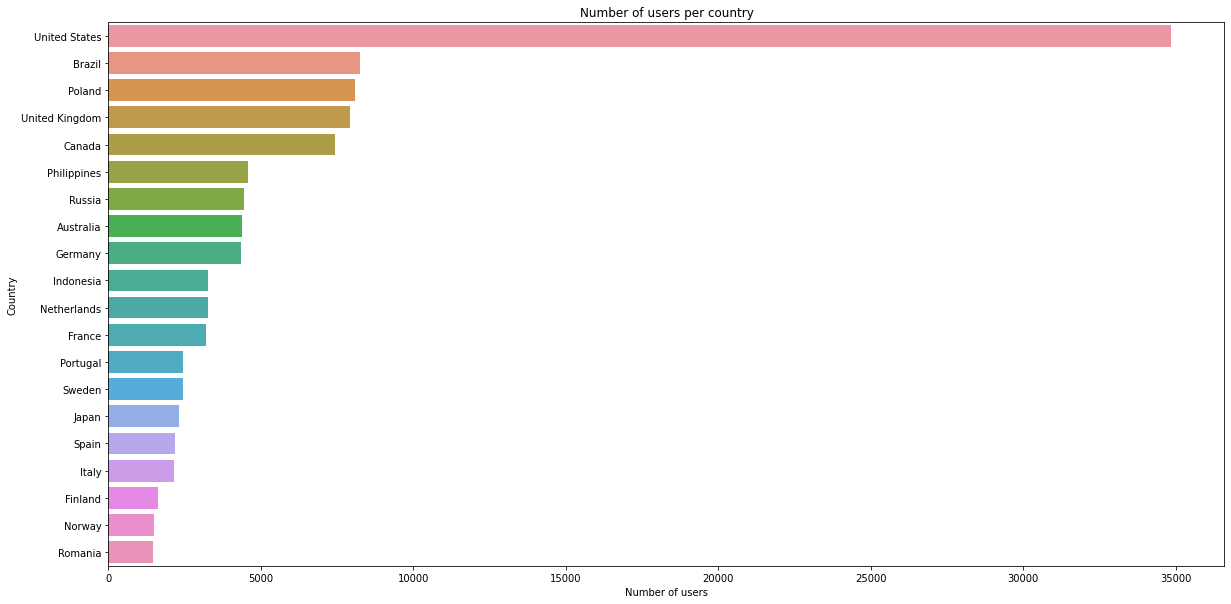

In [38]:
# histogram of the number of users per country
plt.figure(figsize=(20, 10))
sns.countplot(y="country", data=users, order=users["country"].value_counts()[:20].index)
plt.title("Number of users per country")
plt.xlabel("Number of users")
plt.ylabel("Country")
#plt.xticks(rotation=45)
plt.show()

In [25]:
# number of users in France
users[users["country"] == "France"]["user_id"].nunique()


3214

# Studios



In [39]:
df1 = pd.read_csv(data / "animes.csv")
df2 = pd.read_csv(data / "Anime.csv")

ratings = pd.read_csv(data / "ratings.csv")

In [40]:
df_animes = df1.merge(df2,left_on="title",right_on="Name")
df_animes.drop(columns=["season", "start_date", "Rating", "Release_year", "End_year", "Rank", "Name", "Type", "Release_season", "Episodes", "Japanese_name"], inplace=True)
df_animes

,anime_id,title,genres,media,episodes,rating,members,source,Studio,Tags,Description,Content_Warning,Related_Mange,Related_anime,Voice_actors,staff
0,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...","""Follow interstellar bounty hunters Spike Spie...","Drug Use,, Mature Themes,, Nudity,, Violence","Cowboy Bebop: Shooting Star, Cowboy Bebop","Cowboy Bebop Session XX: Mish-Mash Blues, Cowb...","Edward : Aoi Tada, Faye Valentine : Megumi Hay...","Sunrise : Original Creator, Shinichirou Watana..."
1,6,Trigun,"Action,Sci-Fi,Adventure,Comedy,Drama,Shounen",tv,26,8.23,578887.0,manga,MADHOUSE,"Action, Adventure, Comedy, Drama, Shounen, Des...","'“Vash, the Stampede” - worth 60 billion dolla...",Violence,"Trigun, Trigun Maximum, Trigun: Multiple Bullets",Trigun: Badlands Rumble,"Meryl Stryfe : Hiromi Tsuru, Milly Thompson : ...","Yasuhiro Nightow : Original Creator, Satoshi N..."
2,7,Witch Hunter Robin,"Action,Mystery,Police,Supernatural,Drama,Magic",tv,26,7.27,96487.0,original,Sunrise,"Fantasy, Noir, Psychic Powers, Supernatural, S...",'STN is a secret organization charged with cap...,NaN,NaN,NaN,"Amon : Takuma Takewaka, Haruto Sakaki : Jun Fu...","Shuukou Murase : Director, Taku Iwasaki : Musi..."
3,15,Eyeshield 21,"Action,Sports,Comedy,Shounen",tv,145,7.94,152647.0,manga,Gallop,"Action, Comedy, Drama, Shounen, Sports, Footba...","'Sena was always a weak child, constantly havi...","Mature Themes,, Physical Abuse","Eyeshield 21 (Pilot), Eyeshield 21","Eyeshield 21: Maboroshi no Golden Bowl, Eyeshi...","Daikichi Komusubi : Hidenori Sakaki, Kazuki Ju...","Riichiro Inagaki : Original Creator, Yuusuke M..."
4,17,Hungry Heart: Wild Striker,"Slice of Life,Comedy,Sports,Shounen",tv,52,7.58,20934.0,manga,Nippon Animation,"Shounen, Sports, Soccer, Based on a Manga","""Kyousuke Kano aspires to become a professiona...",NaN,Hungry Heart - Wild Striker,NaN,"Kouji Sakai Jefferson : Masaya Takatsuka, Kyos...","Satoshi Saga : Director, Nobuyuki Nakamura : M..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,42331,Renlei Bowuguan,"Slice of Life,Comedy",ona,36,NaN,249.0,original,NaN,"Fantasy, Chinese Animation, Non-Human Protagon...",No synopsis yet - check back soon!,NaN,NaN,NaN,NaN,NaN
5798,42332,Mengyou Dunhuang,"Comedy,Historical,Fantasy",ona,5,NaN,116.0,original,NaN,"Chinese Animation, Short Episodes",No synopsis yet - check back soon!,NaN,NaN,NaN,NaN,NaN
5799,42346,Hakata Bus Terminal Gorou,Comedy,ona,0,NaN,72.0,original,NaN,"Comedy, Short Episodes",'No synopsis yet - check back soon!',NaN,NaN,Hakata Bus Terminal Blues,Takashi Taniguchi\nDirector & Character Design,Takashi Taniguchi : Director & Character Design
5800,42347,Hakata Bus Terminal Blues,"Comedy,Music",music,1,NaN,91.0,original,NaN,"Comedy, Music, Shorts",An official theme song sung by the characters ...,NaN,NaN,Hakata Bus Terminal Gorou,NaN,NaN


In [41]:
df_users_ratings = ratings.merge(users[["user_id", "gender", "location", "birth_date", "join_date", "stats_mean_score", "stats_episodes"]], left_on="user_id", right_on="user_id")

In [42]:
df_studios = df_animes.merge(df_users_ratings, left_on="anime_id", right_on="anime_id")
df_studios.rename({"rating_x" : "average_rating"}, inplace=True)
df_studios.rename({"rating_y" : "rating_user"}, inplace=True)
df_studios

,anime_id,title,genres,media,episodes,rating_x,members,source,Studio,Tags,...,Voice_actors,staff,user_id,rating_y,gender,location,birth_date,join_date,stats_mean_score,stats_episodes
0,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Edward : Aoi Tada, Faye Valentine : Megumi Hay...","Sunrise : Original Creator, Shinichirou Watana...",3,9,Male,"Oslo, Norway",1988-11-11,2004-11-11,7.31,3894.0
1,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Edward : Aoi Tada, Faye Valentine : Megumi Hay...","Sunrise : Original Creator, Shinichirou Watana...",37,10,Female,"San Diego, California",1987-06-18,2005-02-12,8.07,1346.0
2,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Edward : Aoi Tada, Faye Valentine : Megumi Hay...","Sunrise : Original Creator, Shinichirou Watana...",48,9,Female,South-east Asia,1987-12-31,2005-03-12,6.28,11408.0
3,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Edward : Aoi Tada, Faye Valentine : Megumi Hay...","Sunrise : Original Creator, Shinichirou Watana...",66,8,Male,"Calgary, AB",1990-02-09,2005-04-01,7.53,4117.0
4,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Edward : Aoi Tada, Faye Valentine : Megumi Hay...","Sunrise : Original Creator, Shinichirou Watana...",82,7,Male,"Paris, France",1989-06-10,2005-04-29,7.17,2817.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815755,42260,Ninja Collection,Supernatural,tv,13,3.85,12876.0,original,Drawiz,"Horror, Episodic, Ninja, Short Episodes, Super...",...,"Asuka'S Mother, Business Woman : Moemi Otaka, ...","Akira Funada : Producer & Director, Satoshi Um...",59541,2,Female,Toronto,NaN,2008-05-10,9.05,7502.0
815756,42260,Ninja Collection,Supernatural,tv,13,3.85,12876.0,original,Drawiz,"Horror, Episodic, Ninja, Short Episodes, Super...",...,"Asuka'S Mother, Business Woman : Moemi Otaka, ...","Akira Funada : Producer & Director, Satoshi Um...",64816,6,Male,Malaysia,1988-11-11,2008-05-30,7.30,3218.0
815757,42260,Ninja Collection,Supernatural,tv,13,3.85,12876.0,original,Drawiz,"Horror, Episodic, Ninja, Short Episodes, Super...",...,"Asuka'S Mother, Business Woman : Moemi Otaka, ...","Akira Funada : Producer & Director, Satoshi Um...",97939,1,Male,"Lithuania, Panevezys",NaN,2008-09-24,8.81,1132.0
815758,42284,Yuan Long,"Action,Adventure,Fantasy",ona,16,7.30,1484.0,novel,CG Year,"Action, Adventure, Fantasy, Chinese Animation,...",...,"Wang Sheng, Ming Song, Xu Ling, Yan Song, Yao ...","Ren Yuan : Original Creator, Guo Yong : Director",6958,7,Female,Brazil,NaN,2007-07-06,8.45,3574.0


In [43]:
# replace the location in dfFinalStudio with the country, with the help of locationToCountry. If the location is not in locationToCountry, then replace it with "Unknown"
df_studios["country"] = df_studios["location"].apply(
    lambda x: location_to_country[x] if x in location_to_country else ""
)
df_studios

,anime_id,title,genres,media,episodes,rating_x,members,source,Studio,Tags,...,staff,user_id,rating_y,gender,location,birth_date,join_date,stats_mean_score,stats_episodes,country
0,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Sunrise : Original Creator, Shinichirou Watana...",3,9,Male,"Oslo, Norway",1988-11-11,2004-11-11,7.31,3894.0,Norway
1,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Sunrise : Original Creator, Shinichirou Watana...",37,10,Female,"San Diego, California",1987-06-18,2005-02-12,8.07,1346.0,United States
2,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Sunrise : Original Creator, Shinichirou Watana...",48,9,Female,South-east Asia,1987-12-31,2005-03-12,6.28,11408.0,New Zealand
3,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Sunrise : Original Creator, Shinichirou Watana...",66,8,Male,"Calgary, AB",1990-02-09,2005-04-01,7.53,4117.0,United Kingdom
4,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Sunrise : Original Creator, Shinichirou Watana...",82,7,Male,"Paris, France",1989-06-10,2005-04-29,7.17,2817.0,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815755,42260,Ninja Collection,Supernatural,tv,13,3.85,12876.0,original,Drawiz,"Horror, Episodic, Ninja, Short Episodes, Super...",...,"Akira Funada : Producer & Director, Satoshi Um...",59541,2,Female,Toronto,NaN,2008-05-10,9.05,7502.0,Canada
815756,42260,Ninja Collection,Supernatural,tv,13,3.85,12876.0,original,Drawiz,"Horror, Episodic, Ninja, Short Episodes, Super...",...,"Akira Funada : Producer & Director, Satoshi Um...",64816,6,Male,Malaysia,1988-11-11,2008-05-30,7.30,3218.0,Malaysia
815757,42260,Ninja Collection,Supernatural,tv,13,3.85,12876.0,original,Drawiz,"Horror, Episodic, Ninja, Short Episodes, Super...",...,"Akira Funada : Producer & Director, Satoshi Um...",97939,1,Male,"Lithuania, Panevezys",NaN,2008-09-24,8.81,1132.0,Lithuania
815758,42284,Yuan Long,"Action,Adventure,Fantasy",ona,16,7.30,1484.0,novel,CG Year,"Action, Adventure, Fantasy, Chinese Animation,...",...,"Ren Yuan : Original Creator, Guo Yong : Director",6958,7,Female,Brazil,NaN,2007-07-06,8.45,3574.0,Brazil


In [45]:
df_studios["country"].value_counts()

United States     249147
Canada             50306
United Kingdom     49760
Poland             47113
Germany            28655
                   ...  
Angola                 4
Cambodia               3
Seychelles             3
Benin                  2
Chad                   1
Name: country, Length: 161, dtype: int64

In [46]:
df_studios["Studio"].value_counts()

MADHOUSE         87033
A-1 Pictures     42782
Bones            41347
J.C.Staff        32636
Sunrise          32367
                 ...  
Spring 2018          1
Urban Product        1
HiWaPlus             1
MooGoo               1
Spring 2015          1
Name: Studio, Length: 408, dtype: int64

In [47]:
df_studios["user_id"].nunique()

16347

In [48]:
# Aggregate for each Studio the counts for each country
df_studios_countries = (
    df_studios.groupby(["Studio", "country"])
    .agg({"user_id": "count"})
    .rename(columns={"user_id": "num_ratings"})
)  # .reset_index()
df_studios_countries

num_ratings
Studio         country               
2:10 Animation Brazil               1
               Hungary              1
               Norway               1
3xCube         Argentina            2
               Australia           24
...                               ...
ufotable       Venezuela           25
               Vietnam             21
               Warsaw               3
               Yemen                6
               Zimbabwe             5

[15862 rows x 1 columns]

In [49]:
# In df_test, for each Studio, sort the countries by the number of ratings
df_studios_countries = df_studios_countries.groupby(level=0).apply(
    lambda x: x.sort_values("num_ratings", ascending=False)
)
df_studios_countries

num_ratings
Studio         Studio         country                                                 
2:10 Animation 2:10 Animation Brazil                                                 1
                              Hungary                                                1
                              Norway                                                 1
3xCube         3xCube         United States                                        244
                              Poland                                                58
...                                                                                ...
ufotable       ufotable       France - La Réunion - Tromelin Island (EEZ)            1
                              Tunisia                                                1
                              Gabon                                                  1
                              Iran                                                   1
                              Guatemala                                              1

[15862 rows x 1 columns]

In [60]:
# plot df_studios_countries
plt.figure(figsize=(20, 10))
sns.barplot(
    x="num_ratings",
    y="country",
    hue="Studio",
    data=df_studios_countries.reset_index(inplace=True),
    order=df_studios_countries["country"].unique(),
)
plt.title("Number of ratings per country for each Studio")
plt.xlabel("Number of ratings")
plt.ylabel("Country")
plt.show()

# number of ratings per Studio
#df_studios_countries.groupby("Studio").sum()


ValueError: cannot insert country, already exists

<Figure size 1440x720 with 0 Axes>

In [50]:
# Print for Studio == "MADHOUSE"
df_studios_countries.loc["MADHOUSE"].head(10)

num_ratings
Studio   country                    
MADHOUSE United States         26615
         Canada                 5619
         United Kingdom         5298
         Poland                 4955
         Germany                3147
         Philippines            2739
         Brazil                 2510
         Netherlands            2454
         Sweden                 2250
         Australia              2155

In [31]:
df_test.loc["A-1 Pictures"].head(10)

num_ratings
Studio       country                    
A-1 Pictures United States         13165
             United Kingdom         2758
             Poland                 2627
             Canada                 2552
             Germany                1523
             Philippines            1314
             Netherlands            1114
             Australia              1042
             Sweden                 1020
             Brazil                  990

In [34]:
import dask.dataframe as dd

df = dd.read_csv(data /
    "UserAnimeList.csv",
    dtype={
        "username": "object",
        "anime_id": "int64",
        "my_watched_episodes": "int64",
        "my_start_date": "str",
        "my_finish_date": "str",
        "my_score": "int64",
        "my_status": "int64",
        "my_rewatching": "float64",
        "my_rewatching_ep": "int64",
        "my_last_updated": "int64",
        "my_tags": "object",
    },
    usecols=[
        "username",
        "anime_id",
        "my_watched_episodes",
        "my_start_date",
        "my_finish_date",
        "my_score",
        "my_status",
        "my_rewatching",
        "my_rewatching_ep",
        "my_last_updated",
        "my_tags",
    ],
    storage_options={"anon": True},
    blocksize="16 MiB",
).persist()

df

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
npartitions=297,,,,,,,,,,,
,object,int64,int64,object,object,int64,int64,float64,int64,int64,object
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [35]:
df["username"].nunique().compute()

283044

In [36]:
df["anime_id"].nunique().compute()

14478

In [37]:
df.shape[0].compute()

80076112

In [38]:
# group by username and create a column "num_ratings" which counts the number of anime_id per username
user_ratings = (
    df.groupby("username")
    .agg({"anime_id": "count"})
    .rename(columns={"anime_id": "num_ratings"})
).compute()
user_ratings

,num_ratings
username,
karthiga,53
RedvelvetDaisuki,702
Damonashu,351
bskai,457
shuzzable,151
...,...
ScruffyPuffy,27
Torasori,441
onpc,205


In [39]:
# print the rows where username="karthiga"
df[df["username"] == "RedvelvetDaisuki"].compute()


,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
53,RedvelvetDaisuki,1,26,2012-00-00,2014-08-08,8,2,NaN,0,1407479649,NaN
54,RedvelvetDaisuki,7,0,0000-00-00,0000-00-00,0,6,0.0,0,1355478414,NaN
55,RedvelvetDaisuki,16,4,2013-03-23,0000-00-00,4,3,NaN,0,1364134472,NaN
56,RedvelvetDaisuki,19,74,2012-12-14,2012-12-19,9,2,NaN,0,1355935732,NaN
57,RedvelvetDaisuki,20,220,2012-08-00,2012-08-00,9,2,NaN,0,1355471991,NaN
...,...,...,...,...,...,...,...,...,...,...,...
750,RedvelvetDaisuki,35849,15,2018-04-07,0000-00-00,0,1,0.0,0,1525445239,NaN
751,RedvelvetDaisuki,35857,5,2018-04-00,0000-00-00,10,1,0.0,0,1525445957,NaN
752,RedvelvetDaisuki,35860,12,2018-04-02,2018-04-02,5,2,0.0,0,1522821087,NaN
753,RedvelvetDaisuki,36027,12,2018-02-14,2018-02-14,2,2,0.0,0,1518615703,NaN


In [40]:
# sort by my_finish_date
df["my_finish_date"].max().compute()

'6553-00-00'

In [41]:
# Join df with users on username
df_test = df.merge(users_cleaned, left_on="username", right_on="username").persist()
df_test

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
npartitions=297,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,int64,int64,object,object,int64,int64,float64,int64,int64,object,int64,int64,int64,int64,int64,int64,float64,object,object,object,float64,object,object,float64,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [42]:
df_test.shape[0].compute()

33701824